# Classification Analysis: Random Forest

org: **D4G**  project: **BGCO**  task: **random forest**

data: labeled (engage vs. static) dataset highlighting changes in member engagement (visits per week) between first and year of engagement

## Prep the environment

In [1]:
import pandas as pd  # used to manipulate dataframes
import numpy as np # used to manipulate series

## Data Wrangling

### Load Data

* v001 - no postal code data
* v002 - distance to clubhouse, neighborhood included
* v033 - updated distance to clubhouse, no CAMP, no distance outlier, no year1

In [2]:
# read in the dataframe
df_001 = pd.read_csv("D4G_BGCO_Engage_Labeled_ForEDA_v003.csv", encoding = "cp1252")

## Version Control

In [7]:
df = df_001
df.dropna(inplace=True)

In [8]:
print("The data set has {0} rows and {1} columns".format(df.shape[0], df.shape[1]))

The data set has 1814 rows and 8 columns


In [9]:
df.head()

,d4g_member_id,label,member_location.x,sex,Y1_Age,checkin_total,season_most,club_km
0,-2145542991,static,BRIT,F,10,19,winter,3.11
1,-2143641867,engaged,BRIT,M,11,12,winter,0.31
2,-2140123971,static,PYC,M,15,1,winter,1.54
3,-2140034903,static,PYC,M,7,8,winter,11.14
4,-2139051887,engaged,PYC,M,9,35,winter,0.56


In [10]:
df.columns

Index(['d4g_member_id', 'label', 'member_location.x', 'sex', 'Y1_Age',
       'checkin_total', 'season_most', 'club_km'],
      dtype='object')

### Organise Features

Postal code data is incomplete (~23% of the data is missing)

In [11]:
df = df.drop(['d4g_member_id'], axis =1)

categorical_features = ['member_location.x', 'sex', 'season_most']

numerical_features = ['Y1_Age', 'checkin_total', 'club_km']

target = ['label']

## Numerical Features

In [12]:
df[numerical_features].describe()

,Y1_Age,checkin_total,club_km
count,1814.000000,1814.000000,1814.000000
mean,10.593164,10.843991,2.924190
std,3.145116,10.335915,4.760924
min,0.000000,1.000000,0.000000
25%,8.000000,2.000000,0.500000
50%,10.000000,7.000000,1.120000
75%,13.000000,16.000000,3.180000
max,19.000000,39.000000,54.780000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224862E72E8>,
      dtype=object)

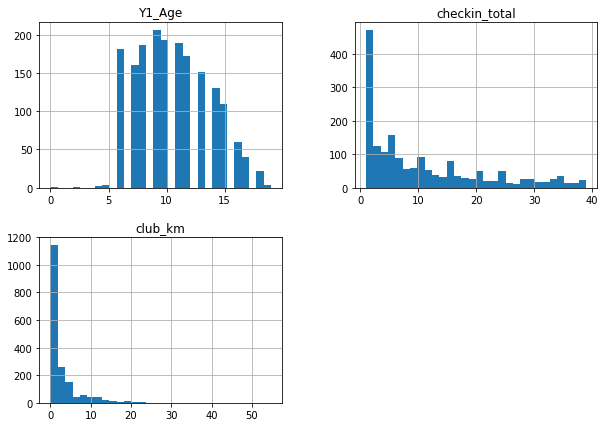

In [13]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224883557B8>,
      dtype=object)

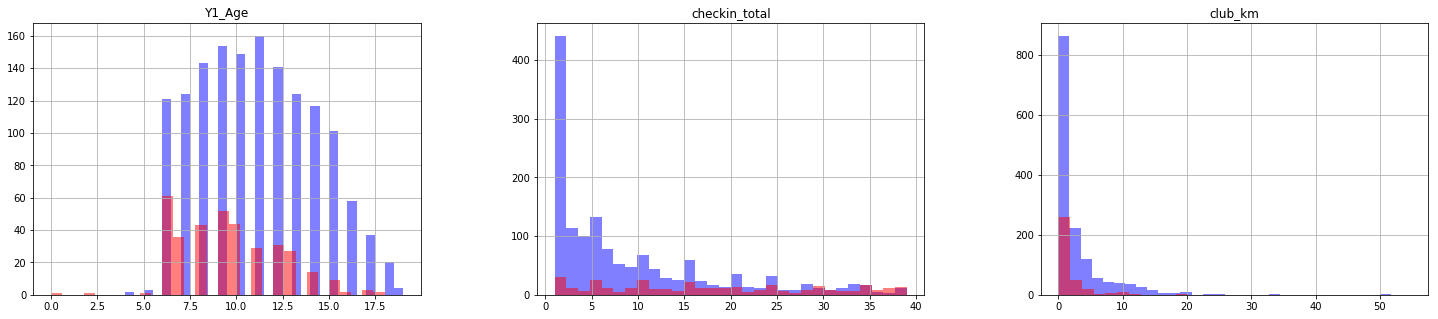

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
df[df.label == "static"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.label == "engaged"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

## Categorical Features

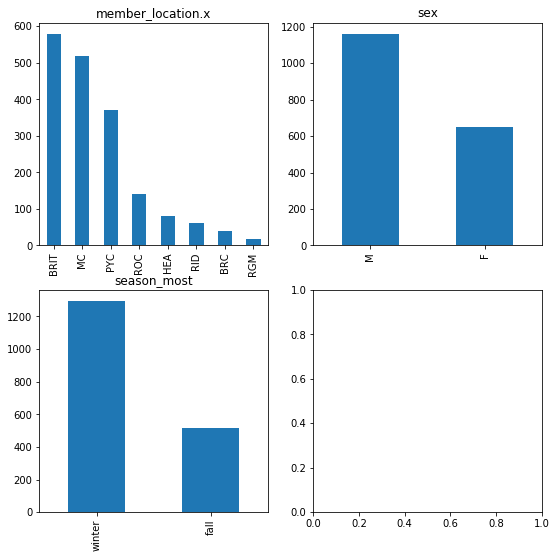

In [19]:
ROWS, COLS = 2, 2
fig, ax = plt.subplots(ROWS, COLS, figsize=(9, 9))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)

Text(0.5, 1.0, 'engaged')

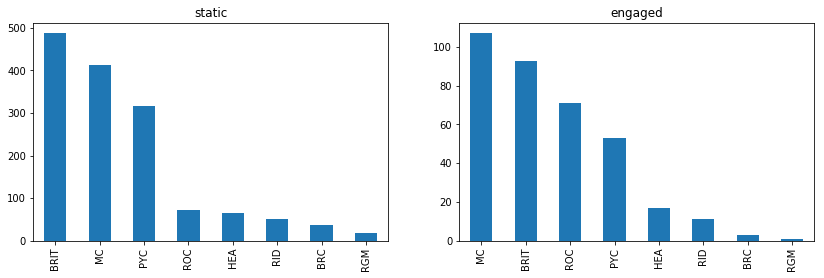

In [21]:
feature = "member_location.x"
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.label == "static"][feature].value_counts().plot('bar', ax=ax[0]).set_title('static')
df[df.label == "engaged"][feature].value_counts().plot('bar', ax=ax[1]).set_title('engaged')

Text(0.5, 1.0, 'engaged')

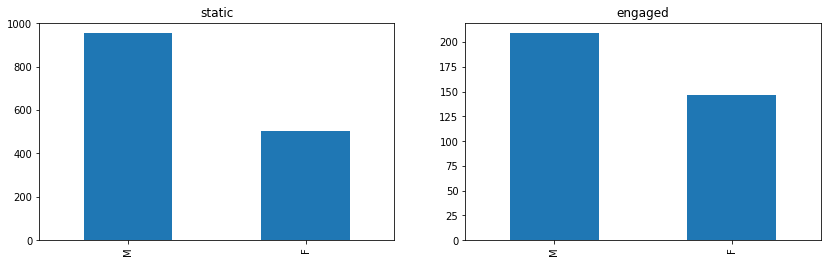

In [22]:
feature = "sex"
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.label == "static"][feature].value_counts().plot('bar', ax=ax[0]).set_title('static')
df[df.label == "engaged"][feature].value_counts().plot('bar', ax=ax[1]).set_title('engaged')

Text(0.5, 1.0, 'engaged')

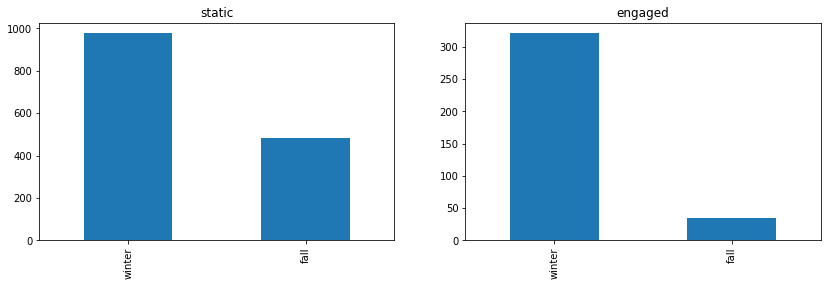

In [23]:
feature = "season_most"
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.label == "static"][feature].value_counts().plot('bar', ax=ax[0]).set_title('static')
df[df.label == "engaged"][feature].value_counts().plot('bar', ax=ax[1]).set_title('engaged')

## Target Feature

Text(0.5, 1.0, 'engaged')

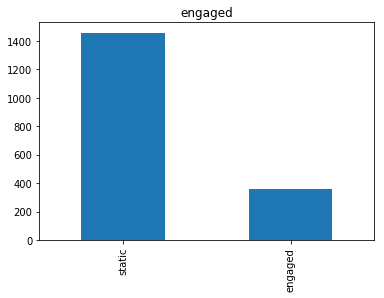

In [24]:
df['label'].value_counts().plot('bar').set_title('engaged')

## Encode Data

In [25]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df.columns:
    if df[column].dtype == object and column != 'customerID':
        if df[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df[column] = le.fit_transform(df[column]) 
        else:
            dummy_columns.append(column)
            
#apply get dummies for selected columns
df = pd.get_dummies(data = df, columns = dummy_columns)

In [22]:
df.head()

,label,first_year,sex,Y1_Age,checkin_total,season_most,club_km,member_location_BRC,member_location_BRIT,member_location_CAMP,member_location_HEA,member_location_MC,member_location_PYC,member_location_RGM,member_location_RID,member_location_ROC
0,1,2013,0,10,19,1,1.22,0,1,0,0,0,0,0,0,0
2,0,2009,1,11,12,1,7.08,0,1,0,0,0,0,0,0,0
3,1,2013,1,15,1,1,7.74,0,0,0,0,0,1,0,0,0
4,1,2009,1,7,8,1,7.51,0,0,0,0,0,1,0,0,0
6,0,2017,1,9,35,1,5.30,0,0,0,0,0,1,0,0,0


## Convert to Arrays

In [ ]:
# Labels are the values we want to predict
labels = np.array(df['label'])  

# Remove the labels from the features
# axis 1 refers to the columns
features = df.drop('label', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

## Random Forest

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# train and test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.89
Accuracy of XGB classifier on test set: 0.82
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        18
           1       0.87      0.92      0.89        73

   micro avg       0.82      0.82      0.82        91
   macro avg       0.72      0.68      0.70        91
weighted avg       0.81      0.82      0.82        91

